## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import json
import os
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt

from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
from haystack.reader.farm import FARMReader
from haystack.reader.transformers import TransformersReader
from haystack.utils import print_answers
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
from haystack.document_store.faiss import FAISSDocumentStore
from haystack.retriever.sparse import ElasticsearchRetriever
from haystack.pipeline import ExtractiveQAPipeline
from haystack.generator.transformers import RAGenerator
from haystack.retriever.dense import DensePassageRetriever

## Load data

The subjQA dataset covers 6 categories, with a trian/dev/test split per category:

In [ ]:
data = Path('./data/subjqa')
!ls {data}

books  electronics  grocery  movies  restaurants  squad_format	tripadvisor


In [ ]:
!ls {data/'electronics/splits'}

dev.csv  test.csv  train.csv


Let's start by picking a single category like `electronics` and loading each CSV in a DataFrame:

In [ ]:
category = "electronics"

In [ ]:
dfs = {p.stem: pd.read_csv(p) for p in (data/'electronics/splits/').glob("*.csv")}

for k,v in dfs.items(): display(v.head(1))

,item_id,domain,nn_mod,nn_asp,query_mod,query_asp,q_review_id,q_reviews_id,question,question_subj_level,ques_subj_score,is_ques_subjective,review_id,review,human_ans_spans,human_ans_indices,answer_subj_level,ans_subj_score,is_ans_subjective
0,B006ZS5ATM,electronics,sore,ear,uncomfortable,headphone,adb20314dbbd8196b7e9fb587b78147f,6e1052529424f3a98d303380155c9dde,What do you think about headphone?,5,0.0,False,197e760a49907baeff809b2ccdfe466f,"I had a smaller headset that went on the ear. After a 8 - 10 hour workday, m...",ANSWERNOTFOUND,"(547, 561)",5,0.0,False


,item_id,domain,nn_mod,nn_asp,query_mod,query_asp,q_review_id,q_reviews_id,question,question_subj_level,ques_subj_score,is_ques_subjective,review_id,review,human_ans_spans,human_ans_indices,answer_subj_level,ans_subj_score,is_ans_subjective
0,B0000BZOGJ,electronics,double,zipper,wide,strap,19d6980d862e90d9170006eaa8516e58,a26d5bd37e06bc8b284ceea6a1eab28d,What is strap?,5,0.0,False,2e675cc6ca63d7052aa195f41fada781,"I purchased this just this week, and while it holds myHP Pavilion DV9830US 1...",ANSWERNOTFOUND,"(1135, 1149)",1,0.0,False


,item_id,domain,nn_mod,nn_asp,query_mod,query_asp,q_review_id,q_reviews_id,question,question_subj_level,ques_subj_score,is_ques_subjective,review_id,review,human_ans_spans,human_ans_indices,answer_subj_level,ans_subj_score,is_ans_subjective
0,B005HMO6A6,electronics,slim,profile,good,texture,04fc9c2d465cfa33839366b248603a6e,45ea1b08b9f0d821d4496669c4c1f782,How is the texture?,1,0.0,False,2eefbde6d07227e04ab45e59760ca3d1,"For my tablets, I wanted to find a way to reduce clutter but still be able t...",ANSWERNOTFOUND,"(1331, 1345)",1,0.0,False


From the [paper](https://arxiv.org/pdf/2004.14283.pdf), here are the breakdown of examples per category / split:

| Domain | Train | Dev | Test | Total |
| :---: | :---: | :---: | :---: | :---: |
| TripAdvisor  | 1165 | 230 | 512 | 1686 |
| Restaurants | 1400 | 267 | 266 | 1683 |
| Movies | 1369 | 261 | 291 | 1677 |
| Books | 1314 | 256 | 345 | 1668 |
| Electronics | 1295 | 255 | 358 | 1659 |
| Grocery | 1124 | 218 | 591 | 1725 |

Let's try to verify them by counting the number of unique question IDs per split:

In [ ]:
for k,v in dfs.items(): print(k, v["q_review_id"].nunique())

train 1295
test 358
dev 255


Looks good.

In [ ]:
dfs["train"].shape

(2345, 19)

In [ ]:
# peek at single example with valid answer
row = dfs["train"].query("human_ans_spans != 'ANSWERNOTFOUND'").iloc[0]
row

item_id                                                                                     B003VAGXWK
domain                                                                                     electronics
nn_mod                                                                                           sleek
nn_asp                                                                                        keyboard
query_mod                                                                                        solid
query_asp                                                                                          key
q_review_id                                                           73e8277fbf438a7ade8f720ddf8a4f47
q_reviews_id                                                          55576d11e04159c488107b442aaff880
question                                                            How are the keys of the  keyboard?
question_subj_level                                                      

In [ ]:
print(f"Question: {row['question']}", "\n")
print(f"Answer: {row['human_ans_spans']}", "\n")
print(f"Review: {row['review']}")

Question: How are the keys of the  keyboard? 

Answer: The illuminated keys are helpful 

Review: I was reluctant to try a wireless keyboard, but due to a wire-chomping kitty, decided it was best to go wireless. I'm so glad I did. This keyboard is sleek and stylish. It has a great feel under my fingertips. I was concerned that a wireless keyboard would be &#34;buggy&#34; and not be efficient, but this keyboard is as good as any corded keyboard. It charges easily via USB port and holds a charge for about ten days. The illuminated keys are helpful, if, like me, your eyes aren't as young as they once were. I already had the logitech unifying plug that plugs into my computer for my mouse and touchpad. I turned the keyboard on and the Logitech plug recognized it right away. I highly recommend this keyboard. ANSWERNOTFOUND


In [ ]:
# check spans match indices
start_idx, end_idx = eval(row["human_ans_indices"])
row['review'][start_idx:end_idx]

'The illuminated keys are helpful'

I noticed that some spans don't match the indices, let's take a look:

In [ ]:
train_df = dfs["train"].copy()

In [ ]:
# convert span indices to tuples
train_df["human_ans_indices"] = train_df["human_ans_indices"].apply(lambda x : eval(x))

In [ ]:
def extract_answer_spans(row):
    start_idx, end_idx = row["human_ans_indices"]
    return row["review"][start_idx:end_idx]

In [ ]:
train_df["answer_spans"] = train_df.apply(extract_answer_spans, axis=1)
train_df.head(1)

,item_id,domain,nn_mod,nn_asp,query_mod,query_asp,q_review_id,q_reviews_id,question,question_subj_level,ques_subj_score,is_ques_subjective,review_id,review,human_ans_spans,human_ans_indices,answer_subj_level,ans_subj_score,is_ans_subjective,answer_spans
0,B006ZS5ATM,electronics,sore,ear,uncomfortable,headphone,adb20314dbbd8196b7e9fb587b78147f,6e1052529424f3a98d303380155c9dde,What do you think about headphone?,5,0.0,False,197e760a49907baeff809b2ccdfe466f,"I had a smaller headset that went on the ear. After a 8 - 10 hour workday, m...",ANSWERNOTFOUND,"(547, 561)",5,0.0,False,ANSWERNOTFOUND


In [ ]:
mask = train_df["human_ans_spans"].str.len() != train_df["answer_spans"].str.len()

In [ ]:
train_df.loc[mask].head()[["human_ans_spans", "answer_spans"]]

,human_ans_spans,answer_spans
15,The anti - glare function does work as described,The anti-glare function does work as described
30,SOUND : The sound is actually very good for background music,SOUND: The sound is actually very good for background music
36,The router took about 10 ' to install and has worked like a charm since then,The router took about 10' to install and has worked like a charm since then
50,sale for as much as $ 750,sale for as much as $750
57,It 's actually much faster to use than booting up my roommate 's 360 or PS4 ...,It's actually much faster to use than booting up my roommate's 360 or PS4 to...


So it seems that some sort of tokenization has been introduced for some examples in the training set. How about the dev and test ones?

In [ ]:
for k,v in dfs.items():
    # convert to tuples
    v["human_ans_indices"] = v["human_ans_indices"].apply(lambda x : eval(x))
    v["answer_spans"] = v.apply(extract_answer_spans, axis=1)
    mask = v["human_ans_spans"].str.len() != v["answer_spans"].str.len()
    print(f"{k} fraction of labelling errors: {len(v.loc[mask]) / len(v):.2f}", "\n")

train fraction of labelling errors: 0.08 

test fraction of labelling errors: 0.08 

dev fraction of labelling errors: 0.07 



Assume we can use the indices as answer spans!

## Convert to SQuAD format

Need this format

```json
{
    "data": [
        {
            "title": "Beyoncé",
            "paragraphs": [
                {
                    "qas": [
                        {
                            "question": "When did Beyonce start becoming popular?",
                            "id": "56be85543aeaaa14008c9063",
                            "answers": [
                                {
                                    "text": "in the late 1990s",
                                    "answer_start": 269
                                }
                            ],
                            "is_impossible": false
                        }
                        ...
                    ],
                    "context": "Beyoncé ..."
                },
                ...
            ]
        }
    ]
}
```

In [ ]:
# peek at single row
row = train_df.query("human_ans_spans != 'ANSWERNOTFOUND'").iloc[0]
row

item_id                                                                                     B003VAGXWK
domain                                                                                     electronics
nn_mod                                                                                           sleek
nn_asp                                                                                        keyboard
query_mod                                                                                        solid
query_asp                                                                                          key
q_review_id                                                           73e8277fbf438a7ade8f720ddf8a4f47
q_reviews_id                                                          55576d11e04159c488107b442aaff880
question                                                            How are the keys of the  keyboard?
question_subj_level                                                      

So we could have the following field mappings:

* title -> item_id
* question -> question
* id -> q_review_id
* answers -> answer_spans (corrects for problems in human_ans_spans)
* answer_start -> first element of human_ans_indices
* is_impossible -> if human_ans_spans == ANSWERNOTFOUND
* context -> review

Groupby `item_id` and build data structure from that? First build up paragraphs from row:

In [ ]:
pars = [
    {"qas": 
     [
         {"question": row["question"], 
          "id": row["q_review_id"], 
          "answers": [
              {"text": row["answer_spans"], 
               "answer_start": row["human_ans_indices"][0]}
          ], 
          "is_impossible": True if row["answer_spans"] == "ANSWERNOTFOUND" else False}],
     "context": row["review"]
    }]
pars

[{'qas': [{'question': 'How are the keys of the  keyboard?',
    'id': '73e8277fbf438a7ade8f720ddf8a4f47',
    'answers': [{'text': 'The illuminated keys are helpful',
      'answer_start': 421}],
    'is_impossible': False}],
  'context': "I was reluctant to try a wireless keyboard, but due to a wire-chomping kitty, decided it was best to go wireless. I'm so glad I did. This keyboard is sleek and stylish. It has a great feel under my fingertips. I was concerned that a wireless keyboard would be &#34;buggy&#34; and not be efficient, but this keyboard is as good as any corded keyboard. It charges easily via USB port and holds a charge for about ten days. The illuminated keys are helpful, if, like me, your eyes aren't as young as they once were. I already had the logitech unifying plug that plugs into my computer for my mouse and touchpad. I turned the keyboard on and the Logitech plug recognized it right away. I highly recommend this keyboard. ANSWERNOTFOUND"}]

Test on a subset of two items:

In [ ]:
sample_df = train_df.query("item_id == 'B006ZS5ATM' | item_id == 'B0074BW614'")
sample_df.head(1)

,item_id,domain,nn_mod,nn_asp,query_mod,query_asp,q_review_id,q_reviews_id,question,question_subj_level,ques_subj_score,is_ques_subjective,review_id,review,human_ans_spans,human_ans_indices,answer_subj_level,ans_subj_score,is_ans_subjective,answer_spans
0,B006ZS5ATM,electronics,sore,ear,uncomfortable,headphone,adb20314dbbd8196b7e9fb587b78147f,6e1052529424f3a98d303380155c9dde,What do you think about headphone?,5,0.0,False,197e760a49907baeff809b2ccdfe466f,"I had a smaller headset that went on the ear. After a 8 - 10 hour workday, m...",ANSWERNOTFOUND,"(547, 561)",5,0.0,False,ANSWERNOTFOUND


In [ ]:
sample_df.shape

(108, 20)

In [ ]:
sample_df.groupby('item_id')['q_review_id'].count()

item_id
B006ZS5ATM      5
B0074BW614    103
Name: q_review_id, dtype: int64

In [ ]:
def create_paragraphs(group):
    pars = []
    
    for idx, row in group.iterrows():
        qas = {"qas": [
            {"question": row["question"],
             "id": row["q_review_id"], 
             "answers": [
                 {"text": row["answer_spans"], 
                  "answer_start": row["human_ans_indices"][0]}
                 ],
             "is_impossible": True if row["answer_spans"] == "ANSWERNOTFOUND" else False}
        ],
               "context": row["review"]
               }
        pars.append(qas)
        
    return pars

In [ ]:
groups = sample_df.groupby('item_id').apply(create_paragraphs).to_frame(name="paragraphs").reset_index().rename(columns={"item_id":'title'})

In [ ]:
groups

,title,paragraphs
0,B006ZS5ATM,"[{'qas': [{'question': 'What do you think about headphone?', 'id': 'adb20314..."
1,B0074BW614,"[{'qas': [{'question': 'What are complaint of these guys?', 'id': '991b7bc67..."


In [ ]:
len(groups.iloc[1]["paragraphs"])

103

In [ ]:
groups.to_dict(orient='records')[0]

{'title': 'B006ZS5ATM',
 'paragraphs': [{'qas': [{'question': 'What do you think about headphone?',
     'id': 'adb20314dbbd8196b7e9fb587b78147f',
     'answers': [{'text': 'ANSWERNOTFOUND', 'answer_start': 547}],
     'is_impossible': True}],
   'context': "I had a smaller headset that went on the ear. After a 8 - 10 hour workday, my ears were throbbing red and painfully sore. With this headset, I can go the same shift and not feel any pain on my ear. They may feel a little on the heavy side, but if you adjust the head phone cups just right and stretch them, you will not have any problems.Quality and sound, words cannot explain. Its so clear and loud, the headset holds in the sound. When I am on a call or listening to music, I do not hear nothing else, but what's coming in through the headset. ANSWERNOTFOUND"},
  {'qas': [{'question': 'What is the sound quality?',
     'id': 'a3cd9be41531e7f23a9882c2a3cb15d4',
     'answers': [{'text': 'Sound quality is awesome', 'answer_start': 490}]

In [ ]:
def convert_to_squad(dfs, output_path: Path):
    for split, df in dfs.items():
        groups = df.groupby('item_id').apply(create_paragraphs).to_frame(name="paragraphs").reset_index().rename(columns={"item_id":'title'})
        squad_data = {}
        squad_data["data"] = groups.to_dict(orient='records')

        with open(output_path/f"{category}-{split}.json", 'w', encoding='utf-8') as f:
            json.dump(squad_data, f)

In [ ]:
squad_path = Path("data/subjqa/squad_format")

In [ ]:
convert_to_squad(dfs, squad_path)

## Evaluate reader

Paper uses BERT-base, so let's try RoBERTa-base which should be a little better:

In [ ]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True, context_window_size=500)

03/07/2021 15:45:39 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 15:45:39 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 15:45:39 - INFO - farm.utils -   Distributed Training: False
03/07/2021 15:45:39 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
03/07/2021 15:45:56 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
03/07/2021 15:45:56 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 15:45:56 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 15:45:56 - INFO - farm.utils -   Distributed Training: False
03/07/2021 15:45:56 - INFO - farm.utils -   Automatic Mixed Precision: None
03/07/2021 

In [ ]:
reader_eval_results = reader.eval_on_file(squad_path, f"{category}-test.json", device='cuda')

Preprocessing Dataset data/subjqa/squad_format/electronics-test.json: 100%|██████████| 718/718 [00:01<00:00, 361.94 Dicts/s]
Evaluating: 100%|██████████| 35/35 [00:19<00:00,  1.76it/s]


In [ ]:
print("Reader Top-N-Accuracy:", reader_eval_results["top_n_accuracy"])
print("Reader Exact Match:", reader_eval_results["EM"])
print("Reader F1-Score:", reader_eval_results["f1"])

Reader Top-N-Accuracy: 0.7047353760445683
Reader Exact Match: 0.2395543175487465
Reader F1-Score: 0.30428376775021326


In the paper they get an F1-score of around 23-24 which is compatible with the 6-7 point difference one sees for BERT vs RoBERTa on SQuAD.

## Fine-tune

In [ ]:
reader.train(data_dir=squad_path,
             train_filename=f"{category}-train.json", 
             dev_filename=f"{category}-dev.json", 
             use_gpu=True, n_epochs=1, save_dir="models/haystack/subjqa/roberta-base-squad2-subjqa",
             batch_size=16,
             evaluate_every=100)

03/07/2021 15:54:47 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 15:54:47 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 15:54:47 - INFO - farm.utils -   Distributed Training: False
03/07/2021 15:54:47 - INFO - farm.utils -   Automatic Mixed Precision: None
Preprocessing Dataset data/subjqa/squad_format/electronics-train.json: 100%|██████████| 2345/2345 [00:02<00:00, 968.32 Dicts/s]
Preprocessing Dataset data/subjqa/squad_format/electronics-dev.json: 100%|██████████| 261/261 [00:01<00:00, 163.06 Dicts/s]
03/07/2021 15:54:59 - WARNING - farm.modeling.prediction_head -   Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": false, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}
03/07/2021 15:54:59 - INFO - farm.modeling.optimizat

In [ ]:
finetuned_reader =  FARMReader(model_name_or_path="models/haystack/subjqa/roberta-base-squad2-subjqa", 
                               use_gpu=True, context_window_size=500)

03/07/2021 16:00:33 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 16:00:33 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 16:00:33 - INFO - farm.utils -   Distributed Training: False
03/07/2021 16:00:33 - INFO - farm.utils -   Automatic Mixed Precision: None
03/07/2021 16:00:35 - WARNING - farm.modeling.prediction_head -   Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": false, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}
03/07/2021 16:00:36 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
03/07/2021 16:00:36 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 16:00:36 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 16:00:36 - INFO - farm.utils -  

In [ ]:
finetuned_reader_eval_results = finetuned_reader.eval_on_file(squad_path, f"{category}-test.json", device='cuda')
print("Reader Top-N-Accuracy:", finetuned_reader_eval_results["top_n_accuracy"])
print("Reader Exact Match:", finetuned_reader_eval_results["EM"])
print("Reader F1-Score:", finetuned_reader_eval_results["f1"])

Preprocessing Dataset data/subjqa/squad_format/electronics-test.json: 100%|██████████| 718/718 [00:01<00:00, 418.02 Dicts/s]
Evaluating: 100%|██████████| 35/35 [00:19<00:00,  1.76it/s]

Reader Top-N-Accuracy: 0.8217270194986073
Reader Exact Match: 0.5793871866295265
Reader F1-Score: 0.6090350878594893


Again, the paper shows values slightly below 0.6 F1-score so we're consistent there. 

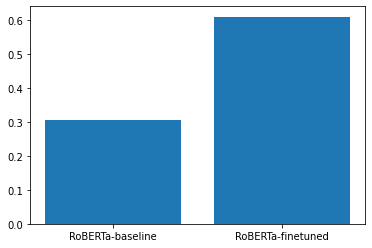

In [ ]:
D = {'RoBERTa-baseline':reader_eval_results["f1"], 'RoBERTa-finetuned':finetuned_reader_eval_results["f1"]}
plt.bar(*zip(*D.items()))
plt.show()

## Retrieval playground

### Boot ES

In [ ]:
! wget -nc https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )
# wait until ES has started
! sleep 30

In [ ]:
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

03/07/2021 16:21:15 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.088s]
03/07/2021 16:21:15 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.011s]
03/07/2021 16:21:15 - INFO - elasticsearch -   GET http://localhost:9200/document [status:200 request:0.004s]
03/07/2021 16:21:15 - INFO - elasticsearch -   PUT http://localhost:9200/document/_mapping [status:200 request:0.021s]
03/07/2021 16:21:15 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.002s]


In [ ]:
document_store.delete_all_documents()

03/07/2021 16:26:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_delete_by_query [status:200 request:4.074s]


### Index docs

In [ ]:
row

item_id                                                                                     B003VAGXWK
domain                                                                                     electronics
nn_mod                                                                                           sleek
nn_asp                                                                                        keyboard
query_mod                                                                                        solid
query_asp                                                                                          key
q_review_id                                                           73e8277fbf438a7ade8f720ddf8a4f47
q_reviews_id                                                          55576d11e04159c488107b442aaff880
question                                                            How are the keys of the  keyboard?
question_subj_level                                                      

In [ ]:
train_df["answer_spans"].apply(lambda x : True if x != "ANSWERNOTFOUND" else False)

0       False
1       False
2       False
3       False
4       False
        ...  
2340     True
2341     True
2342    False
2343    False
2344    False
Name: answer_spans, Length: 2345, dtype: bool

In [ ]:
for k,v in dfs.items():
    v["is_answerable"] = v["answer_spans"].apply(lambda x : 1 if x != "ANSWERNOTFOUND" else 0)

In [ ]:
dfs["train"].iloc[0]

item_id                                                                                     B006ZS5ATM
domain                                                                                     electronics
nn_mod                                                                                            sore
nn_asp                                                                                             ear
query_mod                                                                                uncomfortable
query_asp                                                                                    headphone
q_review_id                                                           adb20314dbbd8196b7e9fb587b78147f
q_reviews_id                                                          6e1052529424f3a98d303380155c9dde
question                                                            What do you think about headphone?
question_subj_level                                                      

In [ ]:
docs = [{"text": row["review"], "meta":{"item_id": row["item_id"], "is_answerable": row["is_answerable"]}} for _, row in dfs["test"].iterrows()]
docs[0]

{'text': 'I purchased this just this week, and while it holds myHP Pavilion DV9830US 17" Laptopsufficiently, it\'s not what I hoped for. First off, the padding around the laptop compartment is barely sufficient. I\'ve seen laptop backpacks that provide much more padding. Also, who makes a laptop backpack without CD sleeves?! There is also a front flap that\'s not sealed, so if you\'re caught in the rain that compartment will get water in it.Overall, I wasn\'t clear on who they designed this for. It was a water bottle holder and some sections that make it seem more like a sport backpack than a student / business travel oriented item, and yet no one is going to go hiking with a 17" laptop... are they? Maybe I\'m wrong.The straps seem solid, though around the shoulders they can dig in a bit. I\'m overweight, so perhaps someone who had thinner shoulders would not have this problem. The overall construction seems fine. Zippers are mostly double which is good, although the exception is the p

In [ ]:
document_store.write_documents(docs)

03/07/2021 16:26:57 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.158s]
03/07/2021 16:26:58 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.220s]


### Retriever

In [ ]:
retriever = ElasticsearchRetriever(document_store=document_store)

### Reader

In [ ]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True, context_window_size=500)

03/07/2021 16:27:06 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 16:27:06 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 16:27:06 - INFO - farm.utils -   Distributed Training: False
03/07/2021 16:27:06 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
03/07/2021 16:27:19 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
03/07/2021 16:27:19 - INFO - farm.utils -   Using device: CUDA 
03/07/2021 16:27:19 - INFO - farm.utils -   Number of GPUs: 1
03/07/2021 16:27:19 - INFO - farm.utils -   Distributed Training: False
03/07/2021 16:27:19 - INFO - farm.utils -   Automatic Mixed Precision: None
03/07/2021 

In [ ]:
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
dfs["test"].query("is_answerable == 1").iloc[0]

item_id                                                                                     B00511PS3C
domain                                                                                     electronics
nn_mod                                                                                          bright
nn_asp                                                                                            lead
query_mod                                                                                         dead
query_asp                                                                                        phone
q_review_id                                                           f61dfa21199ee4fe4b86ed8ad9d0ecf1
q_reviews_id                                                          4a475033ad0bcf1fb29680d05495fbe9
question                                                                    Do I have to use my phone?
question_subj_level                                                      

In [ ]:
query = "is the keyboard good for writing??"
# Logitech keyboard: https://www.amazon.com/dp/B005DKZTMG
asin = "B005DKZTMG"
number_of_answers_to_fetch = 3

prediction = pipe.run(query=query, filters={"item_id": [asin]}, top_k_retriever=10, top_k_reader=number_of_answers_to_fetch)
print(f"Question: {prediction['query']}")
print("\n")
for i in range(number_of_answers_to_fetch):
    print(f"#{i+1}")
    print(f"Answer: {prediction['answers'][i]['answer']}")
    print(f"ASIN: {prediction['answers'][i]['meta']['item_id']}")
    print(f"Is answerable?: {prediction['answers'][i]['meta']['is_answerable']}")
    print(f"Context: {prediction['answers'][i]['context']}")
    print('\n\n')

03/07/2021 16:33:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 46.98 Batches/s]

Question: is the keyboard good for writing??


#1
Answer: feel pretty good to type on
ASIN: B005DKZTMG
Is answerable?: 0
Context: I've used a few different keyboards with my HTPC setup (Microsoft Arc, Apple Bluetooth Wireless) and this is by far the best. The keyboard has a great layout, the keys are a good size and feel pretty good to type on. The touchpad and buttons work well and like the keyboard are a good compromise between usability and size. I also like that it uses RF wireless since it requires zero setup (unlike Bluetooth) and has a fantastic range. I've had it for over 6 months and haven't changed the batteries.



#2
Answer: feel pretty good to type on
ASIN: B005DKZTMG
Is answerable?: 0
Context: I've used a few different keyboards with my HTPC setup (Microsoft Arc, Apple Bluetooth Wireless) and this is by far the best. The keyboard has a great layout, the keys are a good size and feel pretty good to type on. The touchpad and buttons work well and like the keyboard are a goo

In [ ]:
retriever.retrieve(query, filters={"item_id": [asin]}, top_k=3)

03/07/2021 16:46:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]


[{'text': "I've used a few different keyboards with my HTPC setup (Microsoft Arc, Apple Bluetooth Wireless) and this is by far the best. The keyboard has a great layout, the keys are a good size and feel pretty good to type on. The touchpad and buttons work well and like the keyboard are a good compromise between usability and size. I also like that it uses RF wireless since it requires zero setup (unlike Bluetooth) and has a fantastic range. I've had it for over 6 months and haven't changed the batteries. ANSWERNOTFOUND", 'id': '782e11c9-58e6-4be2-96be-cd15a588476e', 'score': 6.134665, 'probability': 0.6828354372720072, 'question': None, 'meta': {'item_id': 'B005DKZTMG', 'is_answerable': 0}, 'embedding': None},
 {'text': "I've used a few different keyboards with my HTPC setup (Microsoft Arc, Apple Bluetooth Wireless) and this is by far the best. The keyboard has a great layout, the keys are a good size and feel pretty good to type on. The touchpad and buttons work well and like the ke

## Generative answers

In [ ]:
faiss_document_store = FAISSDocumentStore(
    faiss_index_factory_str="Flat",
    return_embedding=True
)

In [ ]:
retriever = DensePassageRetriever(
    document_store=faiss_document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)

generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    use_gpu=True,
    top_k_answers=1,
    max_length=200,
    min_length=2,
    embed_title=True,
    num_beams=2,
)

03/07/2021 16:49:34 - INFO - filelock -   Lock 140632482366464 acquired on /root/.cache/huggingface/transformers/52774638a790c9ebc5ce11005b260f79cd4cc389abdab9eaa31e8f09d15b4f46.13b559f49587470ab6d85a7dde13174670a0b61c1b942d1489c96023f5d03772.lock


03/07/2021 16:49:35 - INFO - filelock -   Lock 140632482366464 released on /root/.cache/huggingface/transformers/52774638a790c9ebc5ce11005b260f79cd4cc389abdab9eaa31e8f09d15b4f46.13b559f49587470ab6d85a7dde13174670a0b61c1b942d1489c96023f5d03772.lock


03/07/2021 16:49:35 - INFO - filelock -   Lock 140632482489632 acquired on /root/.cache/huggingface/transformers/41dac75f5df9070331cb0e4bf318c9fdeaef38d9ffd8ca80993c7db830d0c674.446ee898f4788c3ee90f8e7ee5a50281905f509e698f76dc0b583eb74ef973bd.lock


03/07/2021 16:49:43 - INFO - filelock -   Lock 140632482489632 released on /root/.cache/huggingface/transformers/41dac75f5df9070331cb0e4bf318c9fdeaef38d9ffd8ca80993c7db830d0c674.446ee898f4788c3ee90f8e7ee5a50281905f509e698f76dc0b583eb74ef973bd.lock


03/07/2021 16:49:49 - INFO - filelock -   Lock 140632481378464 acquired on /root/.cache/huggingface/transformers/f31ea67434695abc6c4fbe109214416d8b48a44f2fe5a0617e7faa3d6a4f8d05.be8dbf4cc0650b9c5997b3b3bc47d0d6c20749c3871e9285d3b624cd75dd9ee6.lock


03/07/2021 16:49:49 - INFO - filelock -   Lock 140632481378464 released on /root/.cache/huggingface/transformers/f31ea67434695abc6c4fbe109214416d8b48a44f2fe5a0617e7faa3d6a4f8d05.be8dbf4cc0650b9c5997b3b3bc47d0d6c20749c3871e9285d3b624cd75dd9ee6.lock


03/07/2021 16:49:50 - INFO - filelock -   Lock 140632481299184 acquired on /root/.cache/huggingface/transformers/2623d56adfe8cc7bf9275b0c620a0e271ee4004c335173bde56310dc8ea99d4f.714228ba33c6248205269978fd6d0ca0ef96508cbd4a11d894882e71d45fad7c.lock


03/07/2021 16:49:57 - INFO - filelock -   Lock 140632481299184 released on /root/.cache/huggingface/transformers/2623d56adfe8cc7bf9275b0c620a0e271ee4004c335173bde56310dc8ea99d4f.714228ba33c6248205269978fd6d0ca0ef96508cbd4a11d894882e71d45fad7c.lock


03/07/2021 16:50:03 - INFO - filelock -   Lock 140632482366704 acquired on /root/.cache/huggingface/transformers/6337b0203e20d15c98f5e500e1e673c74e71bb8617b2753a53663b9b8e6dfc1a.59948e1fef260da10a0cecb8b6862373c32f40001848a63f985ab4f9d787f3f1.lock


03/07/2021 16:50:03 - INFO - filelock -   Lock 140632482366704 released on /root/.cache/huggingface/transformers/6337b0203e20d15c98f5e500e1e673c74e71bb8617b2753a53663b9b8e6dfc1a.59948e1fef260da10a0cecb8b6862373c32f40001848a63f985ab4f9d787f3f1.lock


03/07/2021 16:50:03 - INFO - filelock -   Lock 140632480585712 acquired on /root/.cache/huggingface/transformers/26cf899a0974235af1f84469ddd94d2ee83c803c23ecead93b511ce8a0744f5c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


03/07/2021 16:50:05 - INFO - filelock -   Lock 140632480585712 released on /root/.cache/huggingface/transformers/26cf899a0974235af1f84469ddd94d2ee83c803c23ecead93b511ce8a0744f5c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


03/07/2021 16:50:06 - INFO - filelock -   Lock 140632480648256 acquired on /root/.cache/huggingface/transformers/d4df3c917efc1bf4cde9515ac4432cddf040d3ddacfad55c85445bc985f58ceb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


03/07/2021 16:50:06 - INFO - filelock -   Lock 140632480648256 released on /root/.cache/huggingface/transformers/d4df3c917efc1bf4cde9515ac4432cddf040d3ddacfad55c85445bc985f58ceb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


03/07/2021 16:50:06 - INFO - filelock -   Lock 140632481070000 acquired on /root/.cache/huggingface/transformers/445caa3aaff6c34b07acdff304db0c8468640baf1139f92c14270fc50cff2eb8.76ea01b4b85ac16e2cec55c398cba7a943d89ab21dfdd973f6630a152e4b9aed.lock


03/07/2021 16:50:07 - INFO - filelock -   Lock 140632481070000 released on /root/.cache/huggingface/transformers/445caa3aaff6c34b07acdff304db0c8468640baf1139f92c14270fc50cff2eb8.76ea01b4b85ac16e2cec55c398cba7a943d89ab21dfdd973f6630a152e4b9aed.lock


03/07/2021 16:50:07 - INFO - filelock -   Lock 140632480647584 acquired on /root/.cache/huggingface/transformers/786598a0d343d4afb34b4f1ee17c14b58fb129abb0b3db386587bea52ffcfb11.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock


03/07/2021 16:50:10 - INFO - filelock -   Lock 140632480647584 released on /root/.cache/huggingface/transformers/786598a0d343d4afb34b4f1ee17c14b58fb129abb0b3db386587bea52ffcfb11.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock


03/07/2021 16:50:10 - INFO - filelock -   Lock 140632480583936 acquired on /root/.cache/huggingface/transformers/f5fdd0c4b41c985f791c9a230cdf051da1cf9480d84e0f5f617667760a24f50f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


03/07/2021 16:50:11 - INFO - filelock -   Lock 140632480583936 released on /root/.cache/huggingface/transformers/f5fdd0c4b41c985f791c9a230cdf051da1cf9480d84e0f5f617667760a24f50f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


03/07/2021 16:50:12 - INFO - filelock -   Lock 140632480269984 acquired on /root/.cache/huggingface/transformers/73d054acda2f2b44f075a0d391ed392e6c53f78356bbf279581786ae35a79e4d.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


03/07/2021 16:50:12 - INFO - filelock -   Lock 140632480269984 released on /root/.cache/huggingface/transformers/73d054acda2f2b44f075a0d391ed392e6c53f78356bbf279581786ae35a79e4d.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


03/07/2021 16:50:12 - INFO - filelock -   Lock 140632481069904 acquired on /root/.cache/huggingface/transformers/a2f0711fd4c199beaf3ff2626c4a723e107e79a8d065099a3d24e7aa361c0f18.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock


03/07/2021 16:50:13 - INFO - filelock -   Lock 140632481069904 released on /root/.cache/huggingface/transformers/a2f0711fd4c199beaf3ff2626c4a723e107e79a8d065099a3d24e7aa361c0f18.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock


03/07/2021 16:50:13 - INFO - filelock -   Lock 140632480382208 acquired on /root/.cache/huggingface/transformers/6288b70ae87b5989f6801120b25a2f6ccf2e88c2f622d94805717b5b043ff71b.bceb1ea6e95a1b39d0a717f315800a39b0847e5cdeeb42615fb498775f632ee6.lock


03/07/2021 16:50:49 - INFO - filelock -   Lock 140632480382208 released on /root/.cache/huggingface/transformers/6288b70ae87b5989f6801120b25a2f6ccf2e88c2f622d94805717b5b043ff71b.bceb1ea6e95a1b39d0a717f315800a39b0847e5cdeeb42615fb498775f632ee6.lock


Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
docs = [{"text": row["review"], "meta":{"name": row["item_id"], "is_answerable": row["is_answerable"]}} for _, row in dfs["test"].iterrows()]
docs[0]

{'text': 'I purchased this just this week, and while it holds myHP Pavilion DV9830US 17" Laptopsufficiently, it\'s not what I hoped for. First off, the padding around the laptop compartment is barely sufficient. I\'ve seen laptop backpacks that provide much more padding. Also, who makes a laptop backpack without CD sleeves?! There is also a front flap that\'s not sealed, so if you\'re caught in the rain that compartment will get water in it.Overall, I wasn\'t clear on who they designed this for. It was a water bottle holder and some sections that make it seem more like a sport backpack than a student / business travel oriented item, and yet no one is going to go hiking with a 17" laptop... are they? Maybe I\'m wrong.The straps seem solid, though around the shoulders they can dig in a bit. I\'m overweight, so perhaps someone who had thinner shoulders would not have this problem. The overall construction seems fine. Zippers are mostly double which is good, although the exception is the p

In [ ]:
faiss_document_store.delete_all_documents()

faiss_document_store.write_documents(docs)

faiss_document_store.update_embeddings(
    retriever=retriever)


03/07/2021 16:59:26 - INFO - haystack.document_store.faiss -   Updating embeddings for 718 docs...
Creating Embeddings: 100%|██████████| 45/45 [00:07<00:00,  5.74 Batches/s]
10000it [00:09, 1032.32it/s]           


In [ ]:
from haystack.pipeline import GenerativeQAPipeline

query= "does it work with ps4?"
pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)
prediction = pipe.run(query=query, top_k_generator=1, top_k_retriever=5)
answers = prediction["answers"]
print()
print(f"Question: {query}")
print(f"RAG answer: {answers[0]['answer'].lower()}")


Question: does it work with ps4?
RAG answer: there were a lot of whining about defective units
